In [523]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "10" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 21
repetitionName =   "testingHopefullycorrectudrli3feat" # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = False
if saveTop:
    saveTopName = "top2udrli"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

33
3.6666666666666665


In [524]:
import pandas as pd
from array import ArrayType
from requests import delete
from tabulate import tabulate
from prettytable import PrettyTable as pt
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 729)
(10, 729)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,N

In [525]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)
# for names in nameDict.keys():
#     print(names, end="        ")
#     x +=1
#     #print(x)



(1, 243)


,fftData-welchDataBC--welchDatacn3,fftData-dataHR--fftDataBC,fftData-fftDataBC--welchDataBC,fftData-welchDataBC--dataHRCV-BCcn3,fftData-fftDataBC--dataHRcn3,fftData-fftDatacn3BC--welchDatacn3BC,fftData-welchDatacn3BC--gaussianDatacn3,fftData-dataCorr1d--welchDatacn3BC,fftData-dataCorr1dBC--welchDatacn3BC,welchData-welchDataBC--welchDatacn3,welchData-dataHR--fftDataBC,welchData-fftDataBC--welchDataBC,welchData-welchDataBC--dataHRCV-BCcn3,welchData-fftDataBC--dataHRcn3,welchData-fftDatacn3BC--welchDatacn3BC,welchData-welchDatacn3BC--gaussianDatacn3,welchData-dataCorr1d--welchDatacn3BC,welchData-dataCorr1dBC--welchDatacn3BC,dataHR-welchDataBC--welchDatacn3,dataHR-dataHR--fftDataBC,dataHR-fftDataBC--welchDataBC,dataHR-welchDataBC--dataHRCV-BCcn3,dataHR-fftDataBC--dataHRcn3,dataHR-fftDatacn3BC--welchDatacn3BC,dataHR-welchDatacn3BC--gaussianDatacn3,dataHR-dataCorr1d--welchDatacn3BC,dataHR-dataCorr1dBC--welchDatacn3BC,dataCorr1d-welchDataBC--welchDatacn3,dataCorr1d-dataHR--fftDataBC,dataCorr1d-fftDataBC--welchDataBC,dataCorr1d-welchDataBC--dataHRCV-BCcn3,dataCorr1d-fftDataBC--dataHRcn3,dataCorr1d-fftDatacn3BC--welchDatacn3BC,dataCorr1d-welchDatacn3BC--gaussianDatacn3,dataCorr1d-dataCorr1d--welchDatacn3BC,dataCorr1d-dataCorr1dBC--welchDatacn3BC,dataFFTCV-BC-welchDataBC--welchDatacn3,dataFFTCV-BC-dataHR--fftDataBC,dataFFTCV-BC-fftDataBC--welchDataBC,dataFFTCV-BC-welchDataBC--dataHRCV-BCcn3,dataFFTCV-BC-fftDataBC--dataHRcn3,dataFFTCV-BC-fftDatacn3BC--welchDatacn3BC,dataFFTCV-BC-welchDatacn3BC--gaussianDatacn3,dataFFTCV-BC-dataCorr1d--welchDatacn3BC,dataFFTCV-BC-dataCorr1dBC--welchDatacn3BC,dataWCV-BC-welchDataBC--welchDatacn3,dataWCV-BC-dataHR--fftDataBC,dataWCV-BC-fftDataBC--welchDataBC,dataWCV-BC-welchDataBC--dataHRCV-BCcn3,dataWCV-BC-fftDataBC--dataHRcn3,dataWCV-BC-fftDatacn3BC--welchDatacn3BC,dataWCV-BC-welchDatacn3BC--gaussianDatacn3,dataWCV-BC-dataCorr1d--welchDatacn3BC,dataWCV-BC-dataCorr1dBC--welchDatacn3BC,dataHRCV-BC-welchDataBC--welchDatacn3,dataHRCV-BC-dataHR--fftDataBC,dataHRCV-BC-fftDataBC--welchDataBC,dataHRCV-BC-welchDataBC--dataHRCV-BCcn3,dataHRCV-BC-fftDataBC--dataHRcn3,dataHRCV-BC-fftDatacn3BC--welchDatacn3BC,dataHRCV-BC-welchDatacn3BC--gaussianDatacn3,dataHRCV-BC-dataCorr1d--welchDatacn3BC,dataHRCV-BC-dataCorr1dBC--welchDatacn3BC,fftDataBC-welchDataBC--welchDatacn3,fftDataBC-dataHR--fftDataBC,fftDataBC-fftDataBC--welchDataBC,fftDataBC-welchDataBC--dataHRCV-BCcn3,fftDataBC-fftDataBC--dataHRcn3,fftDataBC-fftDatacn3BC--welchDatacn3BC,fftDataBC-welchDatacn3BC--gaussianDatacn3,fftDataBC-dataCorr1d--welchDatacn3BC,fftDataBC-dataCorr1dBC--welchDatacn3BC,welchDataBC-welchDataBC--welchDatacn3,welchDataBC-dataHR--fftDataBC,welchDataBC-fftDataBC--welchDataBC,welchDataBC-welchDataBC--dataHRCV-BCcn3,welchDataBC-fftDataBC--dataHRcn3,welchDataBC-fftDatacn3BC--welchDatacn3BC,welchDataBC-welchDatacn3BC--gaussianDatacn3,welchDataBC-dataCorr1d--welchDatacn3BC,welchDataBC-dataCorr1dBC--welchDatacn3BC,dataHRBC-welchDataBC--welchDatacn3,dataHRBC-dataHR--fftDataBC,dataHRBC-fftDataBC--welchDataBC,dataHRBC-welchDataBC--dataHRCV-BCcn3,dataHRBC-fftDataBC--dataHRcn3,dataHRBC-fftDatacn3BC--welchDatacn3BC,dataHRBC-welchDatacn3BC--gaussianDatacn3,dataHRBC-dataCorr1d--welchDatacn3BC,dataHRBC-dataCorr1dBC--welchDatacn3BC,gaussianData-welchDataBC--welchDatacn3,gaussianData-dataHR--fftDataBC,gaussianData-fftDataBC--welchDataBC,gaussianData-welchDataBC--dataHRCV-BCcn3,gaussianData-fftDataBC--dataHRcn3,gaussianData-fftDatacn3BC--welchDatacn3BC,gaussianData-welchDatacn3BC--gaussianDatacn3,gaussianData-dataCorr1d--welchDatacn3BC,gaussianData-dataCorr1dBC--welchDatacn3BC,dataGCVBC-welchDataBC--welchDatacn3,dataGCVBC-dataHR--fftDataBC,dataGCVBC-fftDataBC--welchDataBC,dataGCVBC-welchDataBC--dataHRCV-BCcn3,dataGCVBC-fftDataBC--dataHRcn3,dataGCVBC-fftDatacn3BC--welchDatacn3BC,dataGCVBC-welchDatacn3BC--gaussianDatacn3,dataGCVBC-dataCorr1d--welchDatacn3BC,dataGCVBC-dataCorr1dBC--welchDatacn3BC,gaussianDataBC-welchDataBC--welchDatacn3,gaussianDataBC-dataHR--fftDa

<Figure size 2160x720 with 0 Axes>

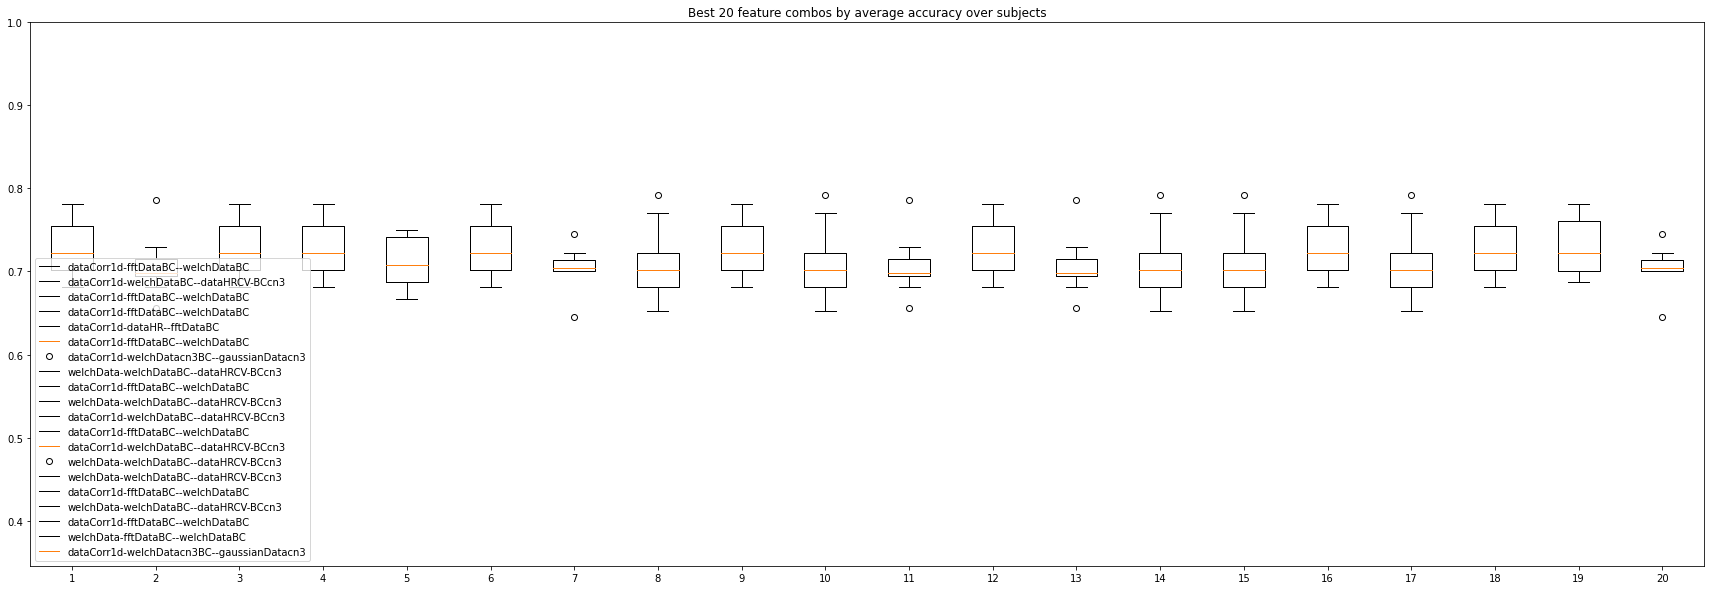

In [526]:
import matplotlib.pyplot as plt
ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
#print(ordeTopAverage)

#np.sort(topPerFeature, axis=1)
np.argsort(comboAverage, axis=1)
sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 25:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature)
    plt.legend(nameArray)
    print("")
else: 
    plt.figure(figsize=[30,10])
    fig, ax = plt.subplots(figsize=[30,10])
    plt.margins(y=1.5)
    ax.set_ylim([np.min(topPerFeature[1:,ordeTopAverage[0][:10]])-0.3,1])
    plt.boxplot(topPerFeature[1:,ordeTopAverage[0][:topAmount]])
    plt.legend(nameArray[ordeTopAverage[0][:topAmount]])
    plt.title(f"Best {topAmount} feature combos by average accuracy over subjects")
    print("")
    


In [527]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.82 : subject 5, feature:dataWCV-BC-welchDataBC--welchDatacn3, kernellinear, C:2.5
Accuracy 0.82 : subject 5, feature:dataGCVBC-welchDataBC--welchDatacn3, kernellinear, C:2.5
Accuracy 0.82 : subject 5, feature:dataFFTCV-BC-welchDataBC--welchDatacn3, kernellinear, C:2.5
Accuracy 0.82 : subject 5, feature:welchDatacn3BC-welchDataBC--welchDatacn3, kernellinear, C:2.5
Accuracy 0.82 : subject 5, feature:dataFFTCV-BCcn3-welchDataBC--welchDatacn3, kernellinear, C:2.5
Accuracy 0.81 : subject 5, feature:welchDatacn3-welchDataBC--welchDatacn3, kernellinear, C:2.5
Accuracy 0.81 : subject 2, feature:dataWCV-BCcn3-welchDataBC--dataHRCV-BCcn3, kernellinear, C:2.5
Accuracy 0.81 : subject 2, feature:dataHRCV-BCcn3-welchDataBC--dataHRCV-BCcn3, kernellinear, C:2.5
Accuracy 0.81 : subject 2, feature:dataWCV-BC-welchDataBC--dataHRCV-BCcn3, kernellinear, C:2.5
Accuracy 0.81 : subject 2, feature:fftDatacn3-welchDataBC--dataHRCV-BCcn3, kernellinear, C:2.5


In [528]:
# top for each feature

In [529]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    newArrayOfTopFeatureNames.append(splitArray)
    
  
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(saveTopName, newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")


Top ten highest accuracies

Accuracy 0.82 : subject 5, feature:dataWCV-BC-welchDataBC--welchDatacn3, kernellinear, C:2.5

Accuracy 0.81 : subject 2, feature:dataWCV-BCcn3-welchDataBC--dataHRCV-BCcn3, kernellinear, C:2.5

Accuracy 0.8 : subject 8, feature:dataFFTCV-BCcn3-dataHR--fftDataBC, kernellinear, C:2.5

Accuracy 0.8 : subject 4, feature:welchData-fftDatacn3BC--welchDatacn3BC, kernellinear, C:2.5

Accuracy 0.77 : subject 1, feature:fftDatacn3-fftDataBC--welchDataBC, kernelsigmoid, C:2.5

Accuracy 0.76 : subject 6, feature:fftData-welchDatacn3BC--gaussianDatacn3, kernellinear, C:2.5

Accuracy 0.74 : subject 9, feature:dataHRcn3BC-fftDataBC--welchDataBC, kernelrbf, C:2.5

Accuracy 0.74 : subject 7, feature:fftDatacn3BC-fftDataBC--welchDataBC, kernelrbf, C:2.5

Accuracy 0.74 : subject 3, feature:gaussianData-fftDataBC--dataHRcn3, kernelsigmoid, C:2.5


In [530]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.69224966 0.71854995 0.66998171 0.72440844 0.72047897
 0.67900455 0.68384202 0.70059442 0.68141289]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728
0,0.693764,0.692575,0.687703,0.713794,0.702988,0.699071,0.72158,0.715993,0.68522,0.706766,0.702788,0.695262,0.709354,0.711641,0.691688,0.711371,0.699113,0.706432,0.699449,0.705777,0.687258,0.690583,0.70027,0.685866,0.6924,0.701852,0.680517,0.68642,0.685003,0.680205,0.708586,0.702964,0.696679,0.718634,0.716432,0.689117,0.697306,0.696524,0.693087,0.709533,0.710069,0.690334,0.711009,0.699484,0.706843,0.697243,0.704282,0.684224,0.693676,0.700579,0.683975,0.69079,0.709052,0.683821,0.684084,0.689306,0.674607,0.70659,0.700235,0.698453,0.720998,0.713885,0.69134,0.694332,0.694957,0.690243,0.709312,0.710262,0.688293,0.708516,0.695984,0.705478,0.686963,0.700849,0.684621,0.681583,0.697762,0.676929,0.675891,0.70175,0.677374,0.685119,0.690867,0.681166,0.702581,0.694992,0.689411,0.716267,0.719967,0.687097,0.691344,0.696766,0.688356,0.704865,0.709224,0.686581,0.711051,0.696924,0.701799,0.692172,0.692824,0.685624,0.683063,0.690678,0.686458,0.681092,0.699961,0.685182,0.704079,0.691035,0.685925,0.715376,0.699762,0.697861,0.722594,0.718501,0.686325,0.704047,0.697811,0.698811,0.710845,0.712283,0.691881,0.712349,0.697825,0.706289,0.68764,0.705661,0.691102,0.698874,0.700694,0.688749,0.688707,0.705

Max average accuracy 0.7245826318742985


In [531]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC-welchDataBC--dataHRCV-BCcn3
linear
0.7245826318742985

dataHRCV-BCcn3-fftDataBC--welchDataBC
linear
0.7245826318742985

fftDatacn3-fftDataBC--welchDataBC
linear
0.7242003367003368

dataGCVBC-fftDataBC--welchDataBC
linear
0.7239969135802469

dataFFTCV-BCcn3-fftDataBC--welchDataBC
linear
0.723712822671156



In [532]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC-welchDataBC--dataHRCV-BCcn3
linear
0.7245826318742985

dataHRCV-BCcn3-fftDataBC--welchDataBC
linear
0.7245826318742985

fftDatacn3-fftDataBC--welchDataBC
linear
0.7242003367003368

dataGCVBC-fftDataBC--welchDataBC
linear
0.7239969135802469

dataFFTCV-BCcn3-fftDataBC--welchDataBC
linear
0.723712822671156



In [533]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728
0,6.243876,6.233176,6.189331,6.424148,6.326894,6.291635,6.494223,6.443939,6.166982,6.36089,6.325095,6.257355,6.384186,6.404766,6.225189,6.402336,6.292014,6.357891,6.295044,6.351989,6.185322,6.215246,6.302431,6.17279,6.231597,6.316667,6.124653,6.177778,6.165025,6.121843,6.377273,6.326673,6.270107,6.467708,6.447885,6.202052,6.275758,6.268718,6.237784,6.385795,6.390625,6.213005,6.399085,6.29536,6.361585,6.275189,6.338542,6.158018,6.243087,6.305208,6.155777,6.217109,6.381471,6.154388,6.156755,6.203756,6.071465,6.359312,6.302115,6.28608,6.488984,6.424968,6.222064,6.24899,6.254609,6.212184,6.383807,6.392361,6.194634,6.376641,6.263857,6.349306,6.18267,6.307639,6.161585,6.134249,6.279861,6.092361,6.083018,6.315751,6.09637,6.166067,6.217803,6.130492,6.323232,6.254924,6.204703,6.446402,6.479703,6.18387,6.222096,6.270896,6.195202,6.343782,6.383018,6.17923,6.399463,6.272317,6.316193,6.229545,6.235417,6.170612,6.147569,6.216098,6.178125,6.12983,6.299653,6.166635,6.336711,6.219318,6.173327,6.438384,6.297854,6.280745,6.503346,6.466509,6.176926,6.336427,6.280303,6.289299,6.397601,6.410543,6.226926,6.411143,6.280429,6.356597,6.188763,6.350947,6.219918,6.289867,6.30625,6.198737,6.198359,6.351

198
9.0
Max total significant accuracy then averaged 0.7245826318742985 
fftDataBC-welchDataBC--dataHRCV-BCcn3
linear
C: 2.5 
546
9.0
Max total significant accuracy then averaged 0.7245826318742985 
dataHRCV-BCcn3-fftDataBC--welchDataBC
linear
C: 2.5 


In [534]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
